# **Proyecto final Machine Learning**

**En este proyecto de Machine Learning se han implementado y comparado cinco modelos de clasificación:**

- Regresión logística
- KNN
- Naive Bayes
- Random Forest
- Árbol de decisión

**Preprocesado de datos:**

- Se ha relaizado el preprocesado del dataset
- Se han creado variables derivadas de las originales para ver si esto mejora el rendimiento de la predicción
  
**Reducción de dimensionalidad en cada modelo:**

Se aplicaron dos técnicas distintas:

- Análisis de Componentes Principales (PCA)
- SelectKBest (basado en ANOVA F-score)
  
La idea es comparar el desempeño de cada modelo bajo ambas estrategias y analizar si existe una diferencia significativa en los resultados.

**Evaluación y Métricas:**

- Se realizaron análisis de resultados y visualizaciones (como gráficas ROC).
- Se interpretaron las métricas obtenidas. 

**Optimización de hiperparámetros:**

- La búsqueda de los mejores hiperparámetros se documenta en un archivo aparte:
  **"Best_parameters_models_classification.ipynb"**, debido al tiempo de ejecución (hasta 13 minutos en Random Forest).

**Importante:** el archivo "Best_parameters_models_classification.ipynb" para ejecutarse correctamente necesita cargar "credit.csv" 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.compose import ColumnTransformer

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from IPython.display import display, HTML

### **Leemos el archivo .csv**

In [2]:
df = pd.read_csv("credit.csv")

### Creamos la matriz de correlación

De cara al procesador de datos nos interesa observar si existen datos que tiene una alta correlación

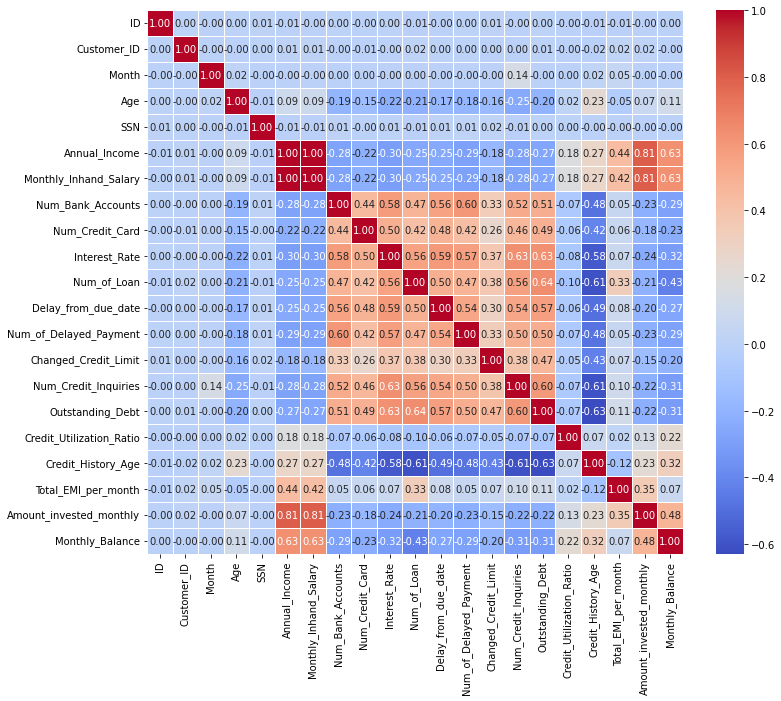

In [3]:
corr_matrix = df.corr(numeric_only=True)

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

Observamos que existen pares de variables que tienen alta correlación, lo que nos indica es que ambas variables aportan la misma información, por lo que podemos prescindir de una de ellas ( en la etapa del preprocesado podremos eliminar una de cada par que tenga alta correlación entre ellas y se observa que los resultados del modelo mejoran). 

## **Preprocesado de datos**

En este primer paso se observa que la columna ***"Type_of_Loan"*** contiene en cada registro tipos de préstamos separados por comas, por lo que para cada tipo de prétamo se generará una nueva columna del tipo ***"MultiLabelBinarizer"***. Además, se ha modificado el valor ***"No Data"*** por ***"No Loan"***. 

In [4]:
columna_tipo_prestamos = 'Type_of_Loan'

# Reemplazamos "No Data" por "No Loan"
df[columna_tipo_prestamos] = df[columna_tipo_prestamos].replace("No Data", "No Loan")

# Eliminamos el conector "and" en el campo de "Type_of_Loan" 
df[columna_tipo_prestamos] = df[columna_tipo_prestamos].replace(r"\band\b", "", regex=True)


# Convertimos la columna a listas correctamente
df[columna_tipo_prestamos] = df[columna_tipo_prestamos].apply(lambda x: [f'"{item.strip()}"' for item in x.split(",")] if isinstance(x, str) else [])

# Aplicamos MultiLabelBinarizer 
mlb = sklearn.preprocessing.MultiLabelBinarizer()
encoded_loans = mlb.fit_transform(df[columna_tipo_prestamos])

# Convertimos la matriz en un DataFrame con los nombres de las columnas
df_encoded = pd.DataFrame(encoded_loans, columns=mlb.classes_)


# Quitamos las comillas dobres de los nombres de las columnas en df_encoded
df_encoded.columns = df_encoded.columns.str.replace('"', '', regex=False)


# Concatenamos el DataFrame codificado con los nuevos campos df original con los 
df = pd.concat([df, df_encoded], axis=1)

# Elimininamos la columna "Type of Loan"
df.pop("Type_of_Loan")
# Convertimos la columna 'Credit_Score' a valores numéricos
df['Credit_Score'] = df['Credit_Score'].map({'Good': 0, 'Poor': 1, 'Standard': 2})

# Mover la columna al final
credit_score_column = df.pop('Credit_Score')  # la extraemos 
df['Credit_Score'] = credit_score_column      # y la colocamos al final


Creamos nuevas variables derivadas a partir de las originales, ya que si sólo preprocesamos las variables originales, al usar "Análisis de componentes principales" graficamos los componentes, se observa que un componente abarca el 70% y esto crea un desequilibrio, por ello se ha decidido crear estas nuevas variables y podemos ver que en el histograma de abajo las el componente principal más grande ya no es un 70%. Por lo que hay mas equilibrio entre los componentes principales

In [5]:

# Evitar división por cero en cada nueva variable derivada

df["Debt_to_Income_Ratio"] = df["Outstanding_Debt"] / (df["Annual_Income"].replace(0, 1e-6))
df["Loan_to_Income_Ratio"] = (df["Total_EMI_per_month"] * 12) / (df["Annual_Income"].replace(0, 1e-6))
df["Credit_Card_to_Bank_Account_Ratio"] = df["Num_Credit_Card"] / (df["Num_Bank_Accounts"].replace(0, 1e-6))
df["Credit_Age_per_Loan"] = df["Credit_History_Age"] / (df["Num_of_Loan"] + 1)  # +1 evita división por cero
df["Credit_Inquiries_per_Year"] = df["Num_Credit_Inquiries"] / (df["Credit_History_Age"] + 1)  # +1 evita división por cero
df["Delayed_Payment_Ratio"] = df["Num_of_Delayed_Payment"] / (df["Num_of_Loan"] + 1)  # +1 evita división por cero


# Ahora podemos calcular el target encoding correctamente
occupation_target_mean = df.groupby("Occupation")["Credit_Score"].mean()
df["Occupation_encoded"] = df["Occupation"].map(occupation_target_mean)
# Eliminar la columna original de "Occupation" si ya no se necesita
df.pop("Occupation")



# Calcular ingreso promedio por ocupación
#occupation_income = df.groupby("Occupation")[["Annual_Income", "Monthly_Inhand_Salary"]].mean()
# Ordenar ocupaciones de menor a mayor ingreso anual
#occupation_order = occupation_income.sort_values("Annual_Income").index.tolist()

# Definir el orden de las categorías "Payment_Behaviour"
payment_order = [
    "Low_spent_Small_value_payments",
    "High_spent_Small_value_payments",
    "Low_spent_Medium_value_payments",
    "High_spent_Medium_value_payments",
    "Low_spent_Large_value_payments",
    "High_spent_Large_value_payments"
]

### **Estandarizar, formalizar columnas**
Datalorel nos permite visualizar distintas estadísticas y la gráfica BoxPlot de cada columna por lo que podemos observar las distintas métricas:  ***count, missing, max, min, mean, outliers***, etc. En función a esta información se ha estandarizado/formalizado las columnas.

In [6]:
column_transformer = ColumnTransformer(transformers=[
    ("x1", MinMaxScaler(), ["Age"]),
    ("x2", MinMaxScaler(), ["Occupation_encoded"]),
    ("x3", RobustScaler(), ["Annual_Income"]),
    ("x4", "drop", ["Monthly_Inhand_Salary"]),
    ("x5", MinMaxScaler(), ["Num_Bank_Accounts"]),
    ("x6", MinMaxScaler(), ["Num_Credit_Card"]),
    ("x7", MinMaxScaler(), ["Interest_Rate"]),
    ("x8", MinMaxScaler(),["Num_of_Loan"]),
    ("x9", "passthrough", ['Auto Loan']),
    ("x10","passthrough", ['Credit-Builder Loan']),
    ("x11", "passthrough", ['Debt Consolidation Loan']),
    ("x12", "passthrough", ['Home Equity Loan']),
    ("x13", "passthrough", ['Mortgage Loan']),
    ("x14", "passthrough", ['No Loan']),
    ("x15", "passthrough", ['Not Specified']),
    ("x16", "passthrough", ['Payday Loan']),
    ("x17", "passthrough", ['Personal Loan']),
    ("x18", "passthrough", ['Student Loan']),
 
    ("x19", RobustScaler(),["Delay_from_due_date"]),
   
    ("x20", "drop",["Num_of_Delayed_Payment"]),
    ("x21", RobustScaler(),["Changed_Credit_Limit"]),    # mejora 2%
    ("x22", "drop",["Num_Credit_Inquiries"]),


    ("x23", OrdinalEncoder(categories=[["Bad", "Standard", "Good"]]) , ['Credit_Mix']), # mejora 2%
    ("x24", RobustScaler(), ['Outstanding_Debt']), # mejora 1%
    ("x25", RobustScaler(), ['Credit_Utilization_Ratio']),
    ("x26", RobustScaler(), ['Credit_History_Age']),
    ("x27", OrdinalEncoder(categories=[["No", "NM", "Yes"]]), ['Payment_of_Min_Amount']),
    ("x28", MinMaxScaler(), ['Total_EMI_per_month']),
    ("x29", "drop", ['Amount_invested_monthly']),
    #("x30", OrdinalEncoder(categories=[payment_order]) , ['Payment_Behaviour']),
    ("x30", "drop" , ['Payment_Behaviour']),
    ("x31", "drop", ['Monthly_Balance']),
   
     # Variables derivadas agregadas aquí
    ("x32", RobustScaler(), ["Debt_to_Income_Ratio"]),
    ("x33", RobustScaler(), ["Loan_to_Income_Ratio"]),
    ("x34", MinMaxScaler(), ["Credit_Card_to_Bank_Account_Ratio"]), 
    ("x35", MinMaxScaler(), ["Credit_Age_per_Loan"]), 
    ("x36", MinMaxScaler(), ["Credit_Inquiries_per_Year"]), 
    ("x37", MinMaxScaler(), ["Delayed_Payment_Ratio"]), 
   
    ("y", "passthrough", ["Credit_Score"])
])
transformed_data = column_transformer.fit_transform(df)
# Verificamos la forma de los datos transformados
print("Forma después de transformación:", transformed_data.shape)

# Obtenemos nombres de columnas transformadas
column_names = column_transformer.get_feature_names_out()

# Convertimos en DataFrame
df_transformed = pd.DataFrame(transformed_data, columns=column_names)

print("Transformación completada")
print(df_transformed.columns)
# con esta linea podemos ver el tamaño en filas y clumnas de nuestro dataset, y nos da una idea 
# del rango de valores que usaremos en el código para encontrar los mejores hiperparámetros de los modelos
print(df_transformed.shape)

Forma después de transformación: (80000, 32)
Transformación completada
Index(['x1__Age', 'x2__Occupation_encoded', 'x3__Annual_Income',
       'x5__Num_Bank_Accounts', 'x6__Num_Credit_Card', 'x7__Interest_Rate',
       'x8__Num_of_Loan', 'x9__Auto Loan', 'x10__Credit-Builder Loan',
       'x11__Debt Consolidation Loan', 'x12__Home Equity Loan',
       'x13__Mortgage Loan', 'x14__No Loan', 'x15__Not Specified',
       'x16__Payday Loan', 'x17__Personal Loan', 'x18__Student Loan',
       'x19__Delay_from_due_date', 'x21__Changed_Credit_Limit',
       'x23__Credit_Mix', 'x24__Outstanding_Debt',
       'x25__Credit_Utilization_Ratio', 'x26__Credit_History_Age',
       'x27__Payment_of_Min_Amount', 'x28__Total_EMI_per_month',
       'x32__Debt_to_Income_Ratio', 'x33__Loan_to_Income_Ratio',
       'x34__Credit_Card_to_Bank_Account_Ratio', 'x35__Credit_Age_per_Loan',
       'x36__Credit_Inquiries_per_Year', 'x37__Delayed_Payment_Ratio',
       'y__Credit_Score'],
      dtype='object')
(80000,

### Dividimos los datos

X = varaibles independientes

y = variable dependiente (nuestro objetivo)

In [7]:
# Separar las variables predictoras (X) y la variable objetivo (y)
X = df_transformed.iloc[:, :-1]  # Variables independientes
y = df_transformed.iloc[:, -1]   # Variable objetivo (variable dependiente)

## Aplicación de PCA (Análisis de componentes principales)

### **Determinamos el número de componentes**

El objetivo es conservar la mayor cantidad de información (varianza) usando menos variables

- Calculamos la varianza explicada acumulada.
- He elegimos el número de componentes que está entre el  80% o 90% porciento de la varianza total.

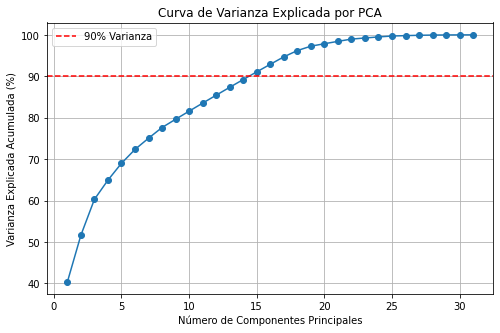

In [8]:
#Inicializamos el PCA con todos los componentes posibles del nuestro dataset
pca = PCA(n_components=X.shape[1], random_state=42)
pca.fit(X)
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% Varianza')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada (%)')
plt.title('Curva de Varianza Explicada por PCA')
plt.legend()
plt.grid(True)
plt.show()

Observamos que la gráfica nos muestra que con 15 componentes principales llegamos al 90% de la varianza acumulada

### **Tabla con informacion detallada de los componentes principales**

- Columna 1: Componente Principal
- Columna 2: Varianza Explicada (%) 
- Columna 3: Principales Variables 	
- Columna 4: Cantidad de Variables Fuerte Impacto

In [9]:
pd.set_option('display.max_rows', None)      
pd.set_option('display.max_columns', None)   
pd.set_option('display.max_colwidth', None)  

pca = PCA(n_components=15).fit(X)
pca.fit(X)

# Obtener la varianza explicada
varianza_explicada = pca.explained_variance_ratio_ * 100  # Convertir a porcentaje

# Obtener las variables que más contribuyen a cada PC
components = pd.DataFrame(np.abs(pca.components_), columns=X.columns)

# Seleccionar las 3 variables más importantes por cada componente
top_features = components.apply(lambda row: row.nlargest(4).index.tolist(), axis=1)

# Crear DataFrame con el resumen
df_pca_summary = pd.DataFrame({
    "Componente Principal": [f"PC{i+1}" for i in range(len(varianza_explicada))],
    "Varianza Explicada (%)": varianza_explicada.round(2),
    "Principales Variables": top_features,  # Guardamos las listas por ahora
    "Cantidad de Variables Fuerte Impacto": components.apply(lambda row: (row > 0.1).sum(), axis=1)
})

# Convertir las listas de variables a formato HTML de lista
df_pca_summary['Principales Variables'] = df_pca_summary['Principales Variables'].apply(
    lambda x: '<ul>' + ''.join(f'<li>{var}</li>' for var in x) + '</ul>'
)

# Mostrar la tabla como HTML en Jupyter con las listas verticales
display(HTML(df_pca_summary.to_html(escape=False)))

# Mostrar el total de variables originales
print(f"Total de variables originales en el dataset: {X.shape[1]}")
print(f"Total de Componentes Principales generados por PCA: {pca.n_components_}")
print(" \n")

Total de variables originales en el dataset: 31
Total de Componentes Principales generados por PCA: 15
 



,Componente Principal,Varianza Explicada (%),Principales Variables,Cantidad de Variables Fuerte Impacto
0,PC1,40.36,x32__Debt_to_Income_Ratiox24__Outstanding_Debtx33__Loan_to_Income_Ratiox27__Payment_of_Min_Amount,9
1,PC2,11.28,x33__Loan_to_Income_Ratiox32__Debt_to_Income_Ratiox3__Annual_Incomex27__Payment_of_Min_Amount,4
2,PC3,8.65,x27__Payment_of_Min_Amountx33__Loan_to_Income_Ratiox32__Debt_to_Income_Ratiox23__Credit_Mix,7
3,PC4,4.64,x3__Annual_Incomex24__Outstanding_Debtx25__Credit_Utilization_Ratiox27__Payment_of_Min_Amount,5
4,PC5,4.06,x19__Delay_from_due_datex21__Changed_Credit_Limitx27__Payment_of_Min_Amountx3__Annual_Income,7
5,PC6,3.35,x25__Credit_Utilization_Ratiox21__Changed_Credit_Limitx27__Payment_of_Min_Amountx24__Outstanding_Debt,7
6,PC7,2.71,x21__Changed_Credit_Limitx3__Annual_Incomex27__Payment_of_Min_Amountx19__Delay_from_due_date,8
7,PC8,2.58,x26__Credit_History_Agex3__Annual_Incomex25__Credit_Utilization_Ratiox14__No Loan,21
8,PC9,1.99,x15__Not Specifiedx13__Mortgage Loanx16__Payday Loanx12__Home Equity Loan,10
9,PC10,1.96,x11__Debt Consolidation Loanx10__Credit-Builder Loanx15__Not Specifiedx16__Payday Loan,10


Observamos que eligiendo estos 15 componentes principales del PC0 al PC15, logramos aproximdamente el 90% de la varianza explicada, es decir, estamos manteniendo aproximadamente el 90% de la información. Además, nos da una idea de qué variables están involucradas en los componentes principales.

### **Histograma componentes principales**

Nos muestra de forma clara el impacto de cada componente principal. El porcentaje de la varianza explicada en función del número de componentes. 
Nota: al crear las variables derivadas hemos podido de alguna manera equilabrar el procentaje de los diferentes componentes principales.

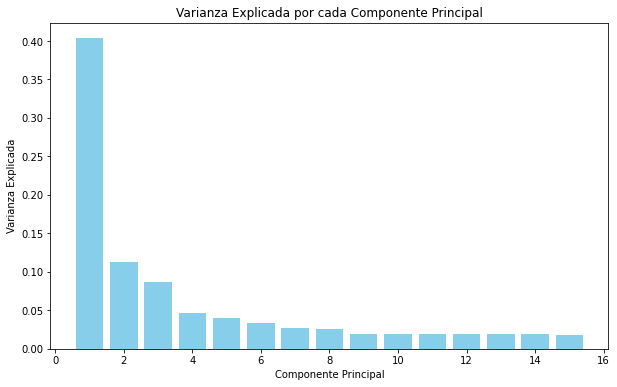

In [10]:
plt.figure(figsize=(10,6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por cada Componente Principal')
plt.show()

In [11]:
cargas = pd.DataFrame(
    pca.components_.T,  
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

print(cargas.head())  # Muestra las primeras variables y sus cargas

                             PC1       PC2       PC3       PC4       PC5  \
x1__Age                -0.030463 -0.016443  0.034866 -0.005955 -0.013991   
x2__Occupation_encoded  0.000233  0.000495  0.000027  0.005214  0.004192   
x3__Annual_Income      -0.175189  0.173730 -0.067691 -0.703360  0.262684   
x5__Num_Bank_Accounts   0.071005  0.019345 -0.075949 -0.001437 -0.050559   
x6__Num_Credit_Card     0.048697  0.008012 -0.033020 -0.024611 -0.039538   

                             PC6       PC7       PC8       PC9      PC10  \
x1__Age                -0.000471  0.024889  0.023608 -0.006849  0.007132   
x2__Occupation_encoded  0.002035 -0.007622  0.002880  0.000985 -0.005910   
x3__Annual_Income      -0.173636 -0.405076  0.344293 -0.028384 -0.054975   
x5__Num_Bank_Accounts   0.021019 -0.001474  0.008678  0.003866  0.019897   
x6__Num_Credit_Card    -0.001486  0.003946 -0.006497  0.008670  0.012290   

                            PC11      PC12      PC13      PC14      PC15  
x1__Age    

#### Matriz de regresión de los componentes principales 

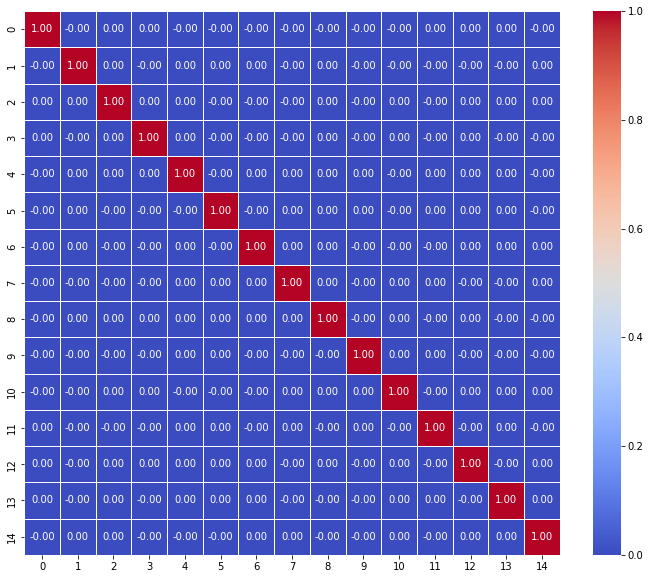

In [12]:
# Aplicamos PCA manteniendo el 15 componentes que representa el 90% de la varianza explicada
df_pca = pca.fit_transform(df_transformed)
df_pca = pd.DataFrame(df_pca)

corr_matrix_pca = df_pca.corr(numeric_only=True)

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_pca, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.show()

Se observa que cada componente principal tiene una alta correlación consigo misma, esto es lo que se espera

# Métodos de clasificación

**Tarda aproximadamente (3 min) si cambiamos n_components = 8 el tiempo disminuye a la mitad**
<br></br>
## 1) Regresión Logística con PCA y SelecktBest


Usamos dos pipelines para evaluar el modelo de **"Regresión Logística"** en el primer pipeline usamos "**Análisis de Componentes Principales"**  y en el segundo pipeline **"SelectkBest"**.


Debido a la diferencia en el tiempo de ejecución en el selecktBest con k = 15, he modificado a k=8 con un tiempo menor de ejecución. 

**Resultados obtenidos:**

**SelectkBest:** n_components= 15, Accuracy promedio: 0.6809749999999999

**SelectkBest:**  n_componentes= 8, Accuracy promedio: 0.6642875

Se ha probrado con plynomials features de grado 3, dando un resultado del accuracy promedio del 67% con SelectkBest, es decir, hay una mejora con respecto al grado dos en aproximadamente un 1%


In [13]:


pipelines = {
    'PCA' : Pipeline([
        ('pca', PCA(n_components=15, random_state=42)),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('clf', LogisticRegression(
            random_state=0,
            max_iter=500,
            class_weight="balanced",
            C=1,
            solver='liblinear',
            penalty='l2'   
        ))
    ]),
    
    'SelectKBest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=8)),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('clf', LogisticRegression(
            random_state=0,
            max_iter=500,
            class_weight="balanced",
            C=1,
            solver='liblinear',
            penalty='l2'   
        ))
    ])
}


# Definimos la validación cruzada
cv_RL = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_pca_RL = None
y_pred_kbest_RL = None
scores_pca_RL = None
scores_kbest_RL = None

for name, pipeline in pipelines.items():
    print(f"Evaluando: {name}")
    scores_RL = cross_val_score(pipeline, X, y, cv=cv_RL, scoring='accuracy', n_jobs=-1)
    print("Accuracy en cada fold:", scores_RL)
    print("Accuracy promedio:", scores_RL.mean())

    y_pred_RL = cross_val_predict(pipeline, X, y, cv=cv_RL, n_jobs=-1)
    # Guardar los resultados en funcion de la estrategia usada
    if name == 'PCA':
        y_pred_pca_RL = y_pred_RL
        scores_pca_RL = scores_RL
    elif name == 'SelectKBest':
        y_pred_kbest_RL = y_pred_RL
        scores_kbest_RL = scores_RL

Evaluando: PCA
Accuracy en cada fold: [0.6319375 0.6406875 0.63775   0.639875  0.65025  ]
Accuracy promedio: 0.6401
Evaluando: SelectKBest
Accuracy en cada fold: [0.6636875 0.6659375 0.6625    0.666375  0.6735625]
Accuracy promedio: 0.6664125000000001


#### Gráfica precisión en cada fold 
El accuracy nos muestra la precisión obtenida en cada fold, se observa que es uniforme en cada fold,por lo que modelo es estable y tiene un rendimiento consistente. El accuracy mean es de aproximandamente del 66.6% en el caso de SelectKBest, mientras que usando PCA es del 64.01%.

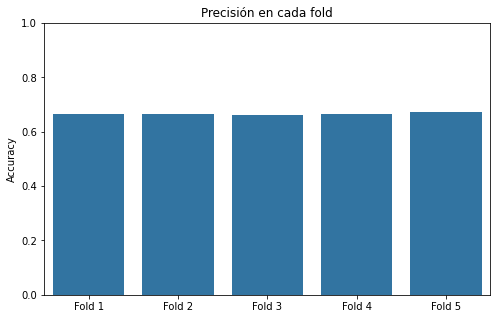

In [14]:

# Gráfico de barras de la precisión por fold
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(scores_kbest_RL))], y=scores_kbest_RL)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Precisión en cada fold')
plt.show()

### **Matriz de confusión**

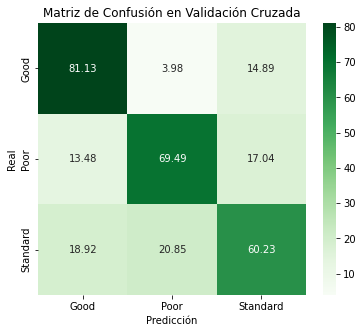

In [15]:
cm_RL = confusion_matrix(y, y_pred_kbest_RL)
cm_percent = cm_RL.astype('float') / cm_RL.sum(axis=1)[:, np.newaxis] * 100
target_names = ["Good", "Poor", "Standard"]
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión en Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 81.13% de los casos "Good".
- Si embargo, 14.89% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa una leve dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 69.49% de los casos "Poor".
- El 17.04% de los casos reales "Poor" son clasificados como "Standard".
- El 13.48% de los casos reales "Poor" son clasificados como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Poor", "Standard" y "Good".

Clase Standard:

- El modelo clasifica correctamente el 60.23% de los casos "Standard".
- El 20.85% de los "Standard" se predicen erróneamente como "Poor".
- El 18.92% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard","Poor"

### **Curva ROC y AUC (PCA)**  - tarda aprox 24 seg

Good AUC = 0.82

Nos indica que el modelo tiene una buena capacidad de discrimnición entre la clase "Good"

Poor AUC = 0.75

Indica que el modelo tiene algo de dificultad para distinguir la clase "Poor" 


Standard AUC = 0.87

El modelo también tiene una buena capacidad de discriminación entre la clase "Standard" y las otras clases, aunque ligeramente un 5% superior a la clase "Good".


Tarda aprox. (23 seg)

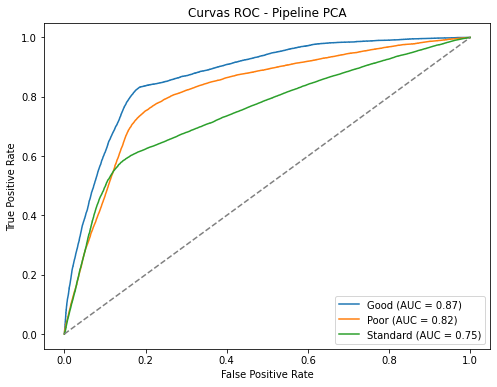

In [16]:

class_labels = ["Good", "Poor", "Standard"]  

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]  

# Elegimos solo el pipeline 'SelectKBest'
pipeline = pipelines['SelectKBest']

# Obtenemos las probabilidades de las predicciones con validación cruzada
y_proba = cross_val_predict(
    pipeline, 
    X, 
    y, 
    cv=cv_RL, 
    method='predict_proba', 
    n_jobs=-1
)

# Graficamos Curvas ROC multicategoría
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')  # grafiamos la diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Pipeline PCA')
plt.legend()
plt.show()

## Importancia de características (SelectkBest) 
(En el caso de las k caracteristicas seleccionadas por el SelectkBest)

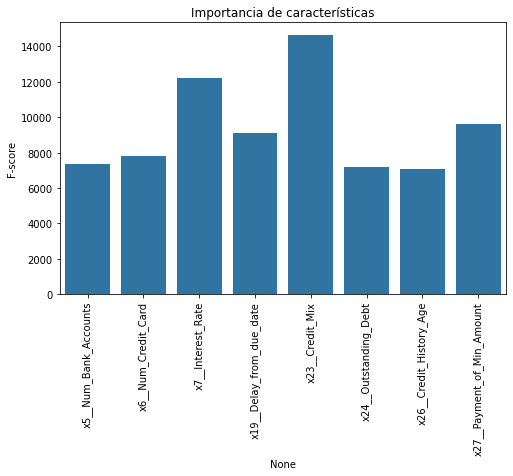

In [17]:
# Extraemos el selector después de ajustar el pipeline
pipeline.named_steps['selector'].fit(X, y)  # Ajustamos solo la selección de características
scores = pipeline.named_steps['selector'].scores_  # obtenemos las puntuaciones de las características

# Obtenemos las características seleccionadas
selected_mask = pipeline.named_steps['selector'].get_support()
selected_features = X.columns[selected_mask]  # obtenemos los nombres de las variables seleccionadas
selected_scores = scores[selected_mask]  # obtenemos las puntuaciones de las características seleccionadas

plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features, y=selected_scores)
plt.xticks(rotation=90)
plt.ylabel('F-score')
plt.title('Importancia de características')
plt.show()

## Classification report

In [18]:
target_names = ["Good", "Poor", "Standard"]  # Agregamos las etiqueta

print(classification_report(y, y_pred_kbest_RL, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_kbest_RL))

              precision    recall  f1-score   support

        Good       0.51      0.81      0.63     14262
        Poor       0.63      0.69      0.66     23199
    Standard       0.81      0.60      0.69     42539

    accuracy                           0.67     80000
   macro avg       0.65      0.70      0.66     80000
weighted avg       0.70      0.67      0.67     80000

Accuracy Score: 0.6664125


Clase Good:

- Precision: de todo lo que el modelo predijo como "Good", el 51% realmente era "Good". 
- Recall: El 0.82 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.63, lo que indica un desempeño moderado del modelo en esta clase."
  
Clase Poor:

- Precision: de todo lo que el modelo predijo como "Poor", el 63% realmente era "Poor". 
- Recall: El 0.69 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.66, lo que indica un desempeño moderado del modelo en esta clase."

Clase Standard:

- Precision: de todo lo que el modelo predijo como "Standard", el 81% realmente era "Standard". 
- Recall: El 0.60 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.69, lo que indica un desempeño moderado del modelo en esta clase."

## 2) The k-nearest neighbors (KNN)
Tarda aprox 1 min 45 seg

In [19]:
# Definimos validación cruzada
cv_KNN = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definimos los pipelines
pipelines = {
    "PCA": Pipeline([
        ('pca', PCA(n_components=15, random_state=42)),  # PCA con 90% varianza explicada
        ('clf', KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski'))
    ]),
    
    "SelectKBest": Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=8)),  # Selección de 8 mejores variables
        ('clf', KNeighborsClassifier(n_neighbors=4, weights='uniform', metric='minkowski'))
    ])
}

y_pred_pca_KNN = None
y_pred_kbest_KNN = None
scores_pca_KNN = None
scores_kbest_KNN = None

for name, pipeline in pipelines.items():
    print(f"Evaluando: {name}")
    scores_KNN = cross_val_score(pipeline, X, y, cv=cv_KNN, scoring='accuracy', n_jobs=-1)
    print("Accuracy en cada fold:", scores_KNN)
    print("Accuracy promedio:", scores_KNN.mean())

    y_pred_KNN = cross_val_predict(pipeline, X, y, cv=cv_KNN, n_jobs=-1)
    # Guardar los resultados en funcion de la estrategia usada
    if name == 'PCA':
        y_pred_pca_KNN = y_pred_KNN
        scores_pca_KNN = scores_KNN
    elif name == 'SelectKBest':
        y_pred_kbest_KNN = y_pred_KNN
        scores_kbest_KNN = scores_KNN

Evaluando: PCA
Accuracy en cada fold: [0.7248125 0.7241875 0.723875  0.7218125 0.7255   ]
Accuracy promedio: 0.7240375
Evaluando: SelectKBest
Accuracy en cada fold: [0.7451875 0.751375  0.744375  0.745125  0.744875 ]
Accuracy promedio: 0.7461875


#### Gráfica precisión en cada fold
El accuracy nos muestra la precisión obtenida en cada fold, se observa que es uniforme en cada fold,por lo que modelo es estable y tiene un rendimiento consistente. El accuracy mean es de aproximandamente del 74%

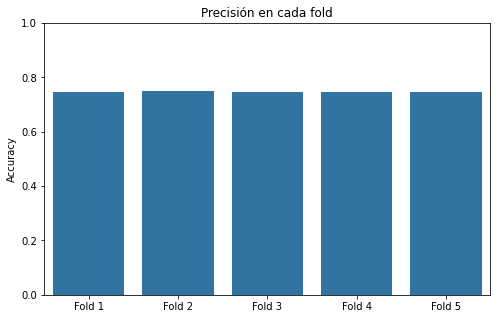

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(scores_kbest_KNN))], y=scores_kbest_KNN)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Precisión en cada fold')
plt.show()

### **Matriz de confusión**

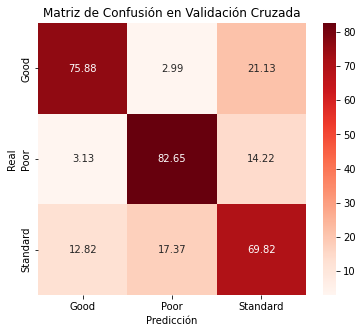

In [21]:
y_knn = y  

cm = confusion_matrix(y_knn, y_pred_kbest_KNN)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizamos la matriz de confusión con un heatmap
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Reds", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión en Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 75.88% de los casos "Good".
- Si embargo, 21.13% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa la dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 82.65% de los casos "Poor".
- El 14.22% de los casos reales "Poor" son clasificados como "Standard".
- Se observa la dificultad del modelo de para diferenciar entre "Poor" y "Standard".

Clase Standard:

- El modelo clasifica correctamente el 69.82% de los casos "Standard".
- El 17.37% de los "Standard" se predicen erróneamente como "Poor".
- El 12.82% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard","Poor"

Curva ROC y AUC

- Good AUC = 0.90
- Poor AUC = 0.90
- Standard AUC = 0.82

El modelo en general tiene regular capacidad de discrimnición entre las clases "Good", "Poor" y "Standard". 

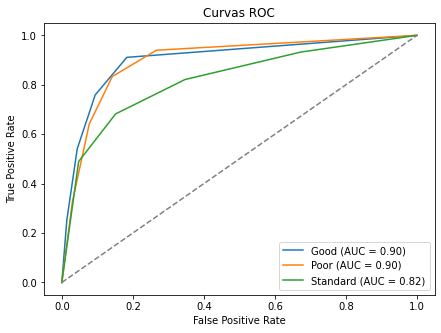

In [22]:
class_labels = ["Good", "Poor", "Standard"]  

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]  

# Obtenemos las probabilidades de las predicciones con validación cruzada
y_prob = cross_val_predict(pipeline, X, y, cv=cv_KNN, method='predict_proba', n_jobs=-1)

# Graficamos las Curvas ROC
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')  # grafiamos la diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

### Importancia de características (SelectkBest)

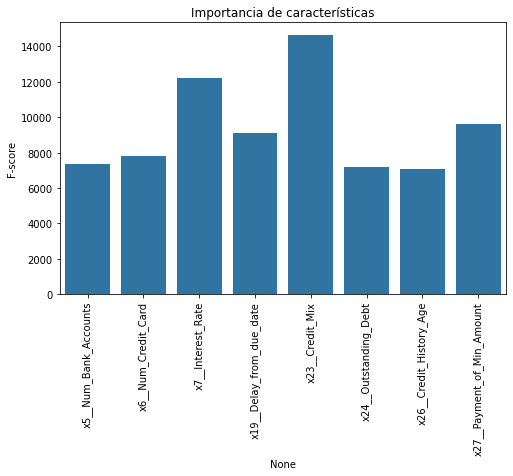

In [23]:
pipeline.named_steps['selector'].fit(X, y)  
scores_KNN = pipeline.named_steps['selector'].scores_  


selected_mask_knn = pipeline.named_steps['selector'].get_support()
selected_features_knn = X.columns[selected_mask_knn]  
selected_scores_knn = scores_KNN[selected_mask_knn]  

plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_knn, y=selected_scores_knn)
plt.xticks(rotation=90)
plt.ylabel('F-score')
plt.title('Importancia de características')
plt.show()

## Classification report

In [24]:
target_names = ["Good", "Poor", "Standard"] 

print(classification_report(y, y_pred_kbest_KNN, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_kbest_KNN))

              precision    recall  f1-score   support

        Good       0.64      0.76      0.69     14262
        Poor       0.71      0.83      0.76     23199
    Standard       0.82      0.70      0.76     42539

    accuracy                           0.75     80000
   macro avg       0.72      0.76      0.74     80000
weighted avg       0.76      0.75      0.75     80000

Accuracy Score: 0.7461875



Clase Good:

- Precision: de todo lo que el modelo predijo como "Good", el 64% realmente era "Good". 
- Recall: El 0.76 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.69, lo que indica un desempeño moderado del modelo en esta clase."
  
Clase Poor:

- Precision: de todo lo que el modelo predijo como "Poor", el 71% realmente era "Poor". 
- Recall: El 0.83 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.76, lo que indica un desempeño moderado alto del modelo en esta clase."

Clase Standard:

- Precision: de todo lo que el modelo predijo como "Standard", el 82% realmente era "Standard". 
- Recall: El 0.70 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.76, lo que indica un desempeño moderado alto del modelo en esta clase."

## 3) Naive-Bayes

Para intentar mejorar modelo, usaremos el número de componentes que reflejen el 100% de la varianza explicar, para ello observamos la gráfica y observamos que con 25 componentes principales obtenemos el 100% de la varianza explicada obteniendo un 0.64% de Accuracy promedio. Ya que n_componentes = 15 que expresa el 90% de la varianza explicada obteniamos un Accuracy promedio 57%.

In [25]:
pipelines = {
    'PCA': Pipeline([
        ('pca', PCA(n_components=25, random_state=42)),
        ('clf', GaussianNB())
    ]),
    'SelectKBest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=6)),
        ('clf', GaussianNB())
    ])
}

# Definimos la validación cruzada
cv_NB = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_pca = None
y_pred_kbest = None
scores_pca_NB = None
scores_kbest_NB = None
for name, pipeline in pipelines.items():
    print(f"Evaluando: {name}")
    scores_NB = cross_val_score(pipeline, X, y, cv=cv_NB, scoring='accuracy', n_jobs=-1)
    print("Accuracy en cada fold:", scores_NB)
    print("Accuracy promedio:", scores_NB.mean())


    y_pred_NB = cross_val_predict(pipeline, X, y, cv=cv_NB, n_jobs=-1)
    # Guardamos los y_pred_NB dependiendo del pipeline que se esté ejecutando
    if name == 'PCA':
        y_pred_pca_NB = y_pred_NB
        scores_pca_NB = scores_NB
    elif name == 'SelectKBest':
        y_pred_kbest_NB = y_pred_NB
        scores_kbest_NB = scores_NB

Evaluando: PCA
Accuracy en cada fold: [0.634625  0.641625  0.6400625 0.6395625 0.6481875]
Accuracy promedio: 0.6408125000000001
Evaluando: SelectKBest
Accuracy en cada fold: [0.6431875 0.6470625 0.6448125 0.644875  0.654    ]
Accuracy promedio: 0.6467875


**Gráfica precisión en cada fold**

El accuracy nos muestra la precisión obtenida en cada fold, se observa que es uniforme en cada fold, por lo que modelo es estable y tiene un rendimiento consistente. El Accuracy promedio es aproximandamente un 64% tanto en PCA como SelectKBest.

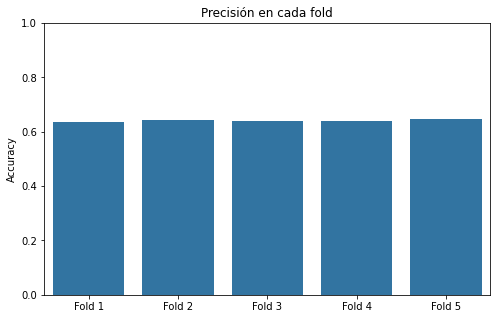

In [26]:
# Gráfico de barras de la precisión por fold
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(scores_pca_NB))], y=scores_pca_NB)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Precisión en cada fold')
plt.show()

### **Matriz de confusión** 
Mostramos la matriz de confusión del modelo "Naive Bayes" con PCA

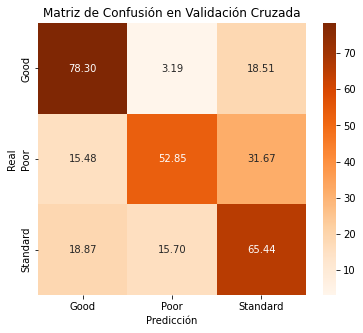

In [27]:
y_NB = y 
cm = confusion_matrix(y_NB, y_pred_pca_NB)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizamos la matriz de confusión con un heatmap
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Oranges", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión en Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 78.30% de los casos "Good".
- Si embargo, 18.51% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 52.85% de los casos "Poor".
- El 31.67% de los casos reales "Poor" son clasificados como "Standard".
- El 15.48% de los casos reales "Poor" son clasificados como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Poor", "Standard" y "Good".

Clase Standard:

- El modelo clasifica correctamente el 65.44% de los casos "Standard".
- El 15.70% de los "Standard" se predicen erróneamente como "Poor".
- El 18.87% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard","Poor"

### **Curva ROC y AUC**

Good AUC = 0.86

Nos indica que el modelo tiene una buena capacidad de discrimnición entre la clase "Good" y las demás clases, 0.87 es bastante alto, lo que sugiere que el modelo es bastante efectivo para identificar correctamente los casos de la clase "Good"

Good AUC = 0.76

El modelo posee una capacidad regular de discriminación entre la clase "Poor" y las otras clases, aunque ligeramente inferior a la clase "Good".

Good AUC = 0.72

El modelo posee una capacidad regular de discriminación de la clase "Standard" de las otras

Tarda aprox. (20 seg)

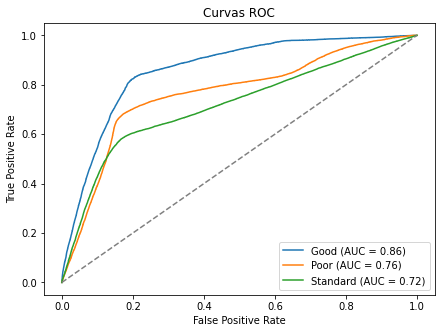

In [28]:
class_labels = ["Good", "Poor", "Standard"]  

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]  

# Obtenemos las probabilidades de las prediccines con validacion cruzada
y_prob = cross_val_predict(pipeline, X, y, cv=cv_NB, method='predict_proba', n_jobs=-1)

# Graficamos las Curvas ROC
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')  # grafismos la diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

### Importancia de características (SelectKBest)

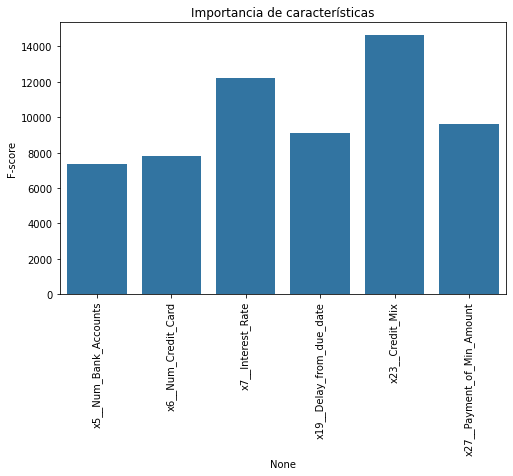

In [29]:
pipeline.named_steps['selector'].fit(X, y)  
scores = pipeline.named_steps['selector'].scores_  


selected_mask_NB = pipeline.named_steps['selector'].get_support()
selected_features_NB = X.columns[selected_mask_NB]  
selected_scores_NB = scores[selected_mask_NB]  

plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_NB, y=selected_scores_NB)
plt.xticks(rotation=90)
plt.ylabel('F-score')
plt.title('Importancia de características')
plt.show()

## Classification report: mdoelo "Naive Bayes" con PCA


In [30]:
target_names = ["Good", "Poor", "Standard"]  
print(classification_report(y, y_pred_pca_NB, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_pca_NB))

              precision    recall  f1-score   support

        Good       0.49      0.78      0.60     14262
        Poor       0.63      0.53      0.58     23199
    Standard       0.74      0.65      0.69     42539

    accuracy                           0.64     80000
   macro avg       0.62      0.66      0.62     80000
weighted avg       0.66      0.64      0.64     80000

Accuracy Score: 0.6408125


Clase Good:

- Precision: de todo lo que el modelo predijo como "Good", el 49% realmente era "Good". 
- Recall: El 0.78 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.60, lo que indica un desempeño moderado del modelo en esta clase."
  
Clase Poor:

- Precision: de todo lo que el modelo predijo como "Poor", el 63% realmente era "Poor". 
- Recall: El 0.53 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.58, lo que indica un desempeño moderado del modelo en esta clase."

Clase Standard:

- Precision: de todo lo que el modelo predijo como "Standard", el 74% realmente era "Standard". 
- Recall: El 0.65 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.69, lo que indica un desempeño moderado del modelo en esta clase."

## 4) Random-Forest (aprox 2 min 24 seg)

El algoritmo de búsqueda de mejores hiperparámetros da como resultado: (tarda aprox  13min)
- n_estimators: 140
- min_samples_split: 10 
- max_depth: 25 
<br></br>

Se han realizado varias pruebas con distintas combinaciones de parámetros(los resultados se pueden ver en la tabla después de ejecutar el modelo).
<br></br>

Cuando usamos 25 componentes principales que expresan el 100% de la varianza explicada, se obtiene un accuracy promedio de 78%, usando n_components = 15 que expresa el 90% de la varianza explicada obteniendo un 73% de accuracy promedio.

**Usaremos unos parámetros que reducen el tiempo de ejecución** (tarda aprox 2 min 46 seg)

- n_estimators: 44
- min_samples_split: 10 
- max_depth: 22 
<br></br>

Y con estos resultados haremos las gráficas

In [31]:
# Definimos el modelo RandomForest con tus hiperparámetros
rf = RandomForestClassifier(
    n_estimators=44,  
    max_depth=22,  
    min_samples_split=10,  
    n_jobs=-1,  
    random_state=42  
)

# Definimos los pipelines con Random Forest
pipelines = {
    'PCA': Pipeline([
        ('pca', PCA(n_components=15, random_state=42)),
        ('clf', rf)
    ]),
    'SelectKBest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=8)),
        ('clf', rf)
    ])
}

# Definimos la validación cruzada
cv_RF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ejecutamos y comparamos ambos pipelines
results = {}

y_pred_pca = None
y_pred_kbest = None
scores_pca_RF = None
scores_kbest_RF = None

for name, pipeline in pipelines.items():
    print(f"Evaluando: {name}")
    scores_RF = cross_val_score(pipeline, X, y, cv=cv_RF, scoring='accuracy', n_jobs=-1)
    print("Accuracy en cada fold:", scores_RF)
    print("Accuracy promedio:", scores_RF.mean())

    y_pred_RF = cross_val_predict(pipeline, X, y, cv=cv_RF, n_jobs=-1)

    # Guardamos y_pred y los scores dependiendo del pipeline
    if name == 'PCA':
        
        y_pred_pca_RF = y_pred_RF
        scores_pca_RF = scores_RF
    elif name == 'SelectKBest':
        y_pred_kbest_RF = y_pred_RF
        scores_kbest_RF = scores_RF

Evaluando: PCA
Accuracy en cada fold: [0.7321875 0.736375  0.7394375 0.736     0.7440625]
Accuracy promedio: 0.7376125
Evaluando: SelectKBest
Accuracy en cada fold: [0.7894375 0.7871875 0.789375  0.7908125 0.7913125]
Accuracy promedio: 0.789625


**Se ha probado diferentes combinaciones de parámetros:**


*Prueba 2:* Tiempo medio de ejecución aprox. 13.45 min

|n_stimators | max_depth | min_samples_split 
|----------|-------------|-----------------|
| 140 | 25  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 25|---| 0.7859 |
| SelectKBest |---|10|0.8025 |

<br></br>


*Prueba 2:* Tiempo medio de ejecución aprox. 13 min

|n_stimators | max_depth | min_samples_split 
|----------|-------------|-----------------|
| 140 | 25  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 25|---| 0.7859 |
| SelectKBest |---|8|0.7943749999999999 |

<br></br>
*Prueba 3:*

|n_stimators | max_depth | min_samples_split 
|----------|-------------|-----------------|
| 44 | 25  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 25| --|0.78 |
| SelectKBest|--|8 |0.784 |

<br></br>
Se comporta casi igual que en la prueba 1, pero con n_stimators = 44
<br></br>
*Prueba 4:*

|n_stimators | max_depth | min_samples_split 
|----------|-------------|-----------------|
| 44 | 22  | 10 |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA |15|--|0.7376 |
| SelectKBest|--|8| |0.7896 |

<br></br>
Baja en 5 puntos en comparación con la prueba 2.

**Gráfica precisión en cada fold**

Se usan los resultados de la prueba 3, porque tiene menos tiempo de ejecucion.

El accuracy nos muestra la precisión obtenida en cada fold, se observa que es uniforme en cada fold, por lo que modelo es estable y tiene un rendimiento consistente. El Accuracy promedio es aproximandamente un 78.96% SelectKBest y 73.76% en PCA.

#### Gráfica accuracy por cada fold evaluación cruzada modelo Random Forest con PCA

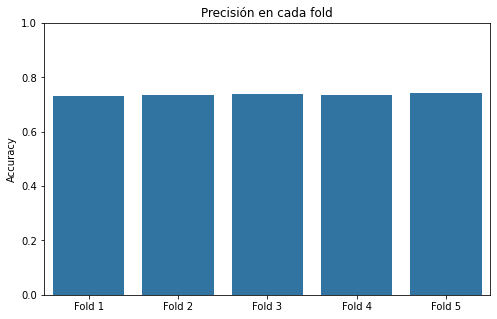

In [32]:
# Gráfico de barras de la precisión por fold
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(scores_pca_RF))], y=scores_pca_RF)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Precisión en cada fold')
plt.show()

#### Gráfica accuracy por cada fold evaluación cruzada modelo Random Forest con SelectKBest

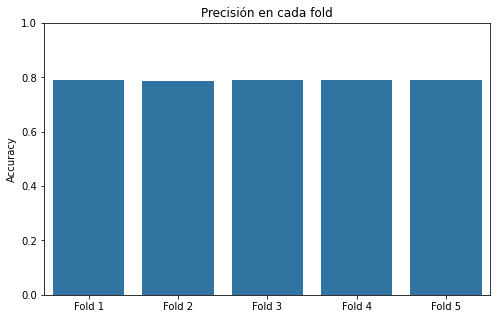

In [33]:
# Gráfico de barras de la precisión por fold
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(scores_kbest_RF))], y=scores_kbest_RF)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Precisión en cada fold')
plt.show()

### **Matriz de confusión Random Forest con PCA**

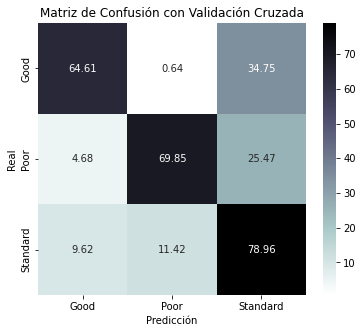

In [34]:
cm = confusion_matrix(y, y_pred_pca_RF)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizamos la matriz de confusión con un heatmap
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="bone_r", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión con Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 64.61% de los casos "Good".
- Si embargo, 34.75% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 69.85% de los casos "Poor".
- El 25.47% de los casos reales "Poor" son clasificados como "Standard".
- Se observa la dificultad del modelo de para diferenciar entre "Poor"y "Standard".

Clase Standard:

- El modelo clasifica correctamente el 78.96% de los casos "Standard".
- El 11.42% de los "Standard" se predicen erróneamente como "Poor".
- El 9.62% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard","Poor"

### **Matriz de confusión Random Forest con SelectKBest**

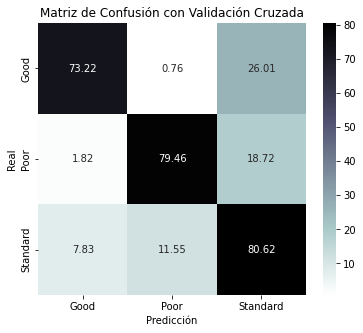

In [35]:
cm = confusion_matrix(y, y_pred_kbest_RF)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizamos la matriz de confusión con un heatmap
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="bone_r", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión con Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 73.22% de los casos "Good".
- Si embargo, 26.01% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 79.46% de los casos "Poor".
- El 18.72% de los casos reales "Poor" son clasificados como "Standard".
- Se observa la dificultad del modelo de para diferenciar entre "Poor"y "Standard".

Clase Standard:

- El modelo clasifica correctamente el 80.62% de los casos "Standard".
- El 11.15% de los "Standard" se predicen erróneamente como "Poor".
- El 7.83% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard","Poor"

### **Curva ROC y AUC**

Good AUC = 0.95

Poor AUC = 0.94

Standard AUC = 0.87

El modelo en general tiene una buena capacidad de discrimnición entre las clases "Good", "Poor" y "Standard"

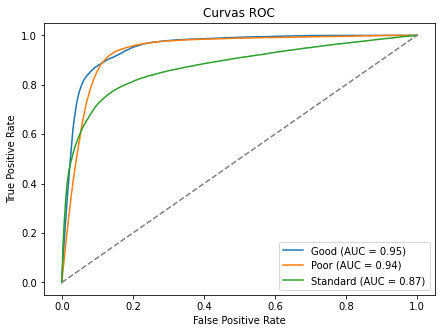

In [36]:
class_labels = ["Good", "Poor", "Standard"]  

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]  

# Obtenemos las probabilidades de las predicciones con validación cruzada
y_prob = cross_val_predict(rf, X, y, cv=cv_RF, method='predict_proba', n_jobs=-1)

# Graficamos las Curvas ROC
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')  # grafiamos la diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

## Classification report Random Forest + PCA

In [37]:
target_names = ["Good", "Poor", "Standard"]  

print(classification_report(y, y_pred_pca_RF, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_pca_RF))

              precision    recall  f1-score   support

        Good       0.64      0.65      0.64     14262
        Poor       0.77      0.70      0.73     23199
    Standard       0.76      0.79      0.77     42539

    accuracy                           0.74     80000
   macro avg       0.72      0.71      0.72     80000
weighted avg       0.74      0.74      0.74     80000

Accuracy Score: 0.7376125


## Classification report Random Forest + SelectKBest

In [38]:
target_names = ["Good", "Poor", "Standard"]  

print(classification_report(y, y_pred_kbest_RF, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_kbest_RF))

              precision    recall  f1-score   support

        Good       0.74      0.73      0.73     14262
        Poor       0.79      0.79      0.79     23199
    Standard       0.81      0.81      0.81     42539

    accuracy                           0.79     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.79      0.79      0.79     80000

Accuracy Score: 0.789625


## 5) Árbol de decisión (33 seg)

In [39]:
# establecemos los hiperparametros
dt = DecisionTreeClassifier(
    max_depth=15,          
    min_samples_split=10,  
    random_state=42
)
# definimos los pipelines
pipelines = {
    'PCA': Pipeline([
        ('pca', PCA(n_components=25, random_state=42)), # usamos el 100% de la varianza explicada para mejorar el accuracy promedio
        ('clf', dt)
    ]),
    'SelectKBest': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=10)),
        ('clf', dt)
    ])
}

# Validacion cruzada
cv_DT = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ejecutamos y comparamos ambos pipelines
results = {}

y_pred_pca_DT = None
y_pred_kbest_DT = None
scores_pca_DT = None
scores_kbest_DT = None

for name, pipeline in pipelines.items():
    print(f"Evaluando: {name}")
    scores_DT = cross_val_score(pipeline, X, y, cv=cv_DT, scoring='accuracy', n_jobs=-1)
    print("Accuracy en cada fold:", scores_DT)
    print("Accuracy promedio:", scores_DT.mean())

    y_pred_DT = cross_val_predict(pipeline, X, y, cv=cv_DT, n_jobs=-1)

    # Guardamos predicciones y scores
    if name == 'PCA':
        y_pred_pca_DT = y_pred_DT
        scores_pca_DT = scores_DT
    elif name == 'SelectKBest':
        y_pred_kbest_DT = y_pred_DT
        scores_kbest_DT = scores_DT

Evaluando: PCA
Accuracy en cada fold: [0.7033125 0.698375  0.7055    0.7003125 0.709    ]
Accuracy promedio: 0.7033
Evaluando: SelectKBest
Accuracy en cada fold: [0.7323125 0.7430625 0.7399375 0.7375625 0.7435   ]
Accuracy promedio: 0.739275


**Se ha probado diferentes combinaciones de parámetros:**


*Prueba 1:* Tiempo medio de ejecución aprox. 25 segundos.

| max_depth | min_samples_split 
|-------------|-----------------|
| 15  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 15|---| 0.7033 |
| SelectKBest |---|10|0.7392 |

<br></br>

*Prueba 2:* Tiempo medio de ejecución aprox. 25 segundos.

| max_depth | min_samples_split 
|-------------|-----------------|
| 15  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 15|---| 0.67.27 |
| SelectKBest |---|8|0.7341 |

<br></br>
*Prueba 3:* tiempo aproximado de ejecución 35 segundos

| max_depth | min_samples_split 
|-------------|-----------------|
| 25  | 10  |
<br></br>
|Strategy| n_components|k| Accuracy mean |
|--------|-------------|-|---------------|
| PCA | 25| --|0.7033 |
| SelectKBest|--|8 |0.7342 |

<br></br>

### **Matriz de confusión Árbol de Decisión con PCA**

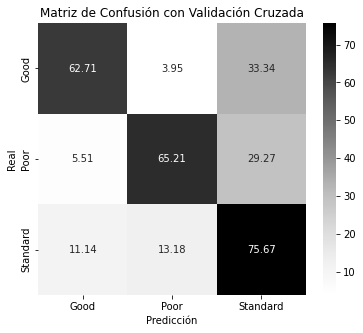

In [40]:
# Matriz de confusión
cm = confusion_matrix(y, y_pred_pca_DT)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizar matriz de confusión
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greys", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión con Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 62.71% de los casos "Good".
- Si embargo, 33.34% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 65.21% de los casos "Poor".
- El 27.27% de los casos reales "Poor" son clasificados como "Standard".
- Se observa la dificultad del modelo de para diferenciar entre "Poor"y "Standard".

Clase Standard:

- El modelo clasifica correctamente el 75.67% de los casos "Standard".
- El 13.18% de los "Standard" se predicen erróneamente como "Poor".
- El 11.14% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard" y "Poor"

### **Matriz de confusión Árbol de Decisión con SelectKBest**

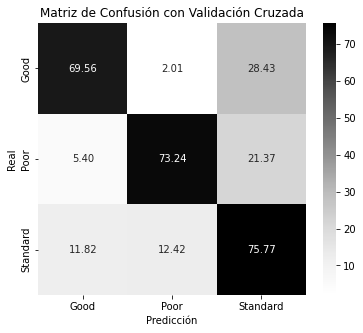

In [41]:
cm = confusion_matrix(y, y_pred_kbest_DT)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualizamos la matriz de confusión
target_names = ["Good", "Poor", "Standard"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greys", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión con Validación Cruzada")
plt.show()

Clase Good

- El modelo clasifica un 69.56% de los casos "Good".
- Si embargo, 28.43% de los casos reales "Good" son clasificados erroneamente como "Standard"
- Se observa dificultad del modelo de para diferenciar entre "Good" y "Standard"

Clase Poor

- El modelo clasifica correctamente el 73.24% de los casos "Poor".
- El 21.37% de los casos reales "Poor" son clasificados como "Standard".
- Se observa la dificultad del modelo de para diferenciar entre "Poor"y "Standard".

Clase Standard:

- El modelo clasifica correctamente el 75.77% de los casos "Standard".
- El 12.42% de los "Standard" se predicen erróneamente como "Poor".
- El 11.82% de los "Standard" se predicen erróneamente como "Good".
- Se observa la dificultad del modelo de para diferenciar entre "Good","Standard" y "Poor"

### **Curva ROC y AUC**

Good AUC = 0.89

Poor AUC = 0.87

Standard AUC = 0.81

El modelo en general tiene una buena capacidad de discrimnición entre las clases "Good", "Poor" y "Standard"

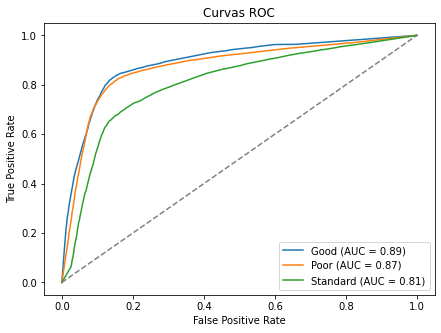

In [42]:
class_labels = ["Good", "Poor", "Standard"]  

# Binarizar etiquetas
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]  

# Obtenemos las probabilidades de las predicción con validación cruzada
y_proba = cross_val_predict(dt, X, y, cv=cv_DT, method='predict_proba', n_jobs=-1)

# Graficamos las Curvas ROC
plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

## Classification report Árbol de Decisión + PCA

In [43]:
target_names = ["Good", "Poor", "Standard"]  
print(classification_report(y, y_pred_pca_DT, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_pca_DT))

              precision    recall  f1-score   support

        Good       0.60      0.63      0.61     14262
        Poor       0.71      0.65      0.68     23199
    Standard       0.74      0.76      0.75     42539

    accuracy                           0.70     80000
   macro avg       0.68      0.68      0.68     80000
weighted avg       0.70      0.70      0.70     80000

Accuracy Score: 0.7033


Clase Good:

- Precision: de todo lo que el modelo predijo como "Good", el 60% realmente era "Good". 
- Recall: El 0.63 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.61, lo que indica un desempeño moderado del modelo en esta clase."
  
Clase Poor:

- Precision: de todo lo que el modelo predijo como "Poor", el 71% realmente era "Poor". 
- Recall: El 0.65 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.68, lo que indica un desempeño moderado del modelo en esta clase."

Clase Standard:

- Precision: de todo lo que el modelo predijo como "Standard", el 74% realmente era "Standard". 
- Recall: El 0.76 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.75, lo que indica un desempeño moderado del modelo en esta clase."

## Classification report Árbol de Decisión + SelectKBest

In [44]:
target_names = ["Good", "Poor", "Standard"]  

print(classification_report(y, y_pred_kbest_DT, target_names=target_names))
print('Accuracy Score:', accuracy_score(y, y_pred_kbest_DT))

              precision    recall  f1-score   support

        Good       0.61      0.70      0.65     14262
        Poor       0.75      0.73      0.74     23199
    Standard       0.78      0.76      0.77     42539

    accuracy                           0.74     80000
   macro avg       0.72      0.73      0.72     80000
weighted avg       0.74      0.74      0.74     80000

Accuracy Score: 0.739275


Clase Good:

- Precision: de todo lo que el modelo predijo como "Good", el 61% realmente era "Good". 
- Recall: El 0.70 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.65, lo que indica un desempeño moderado del modelo en esta clase."
  
Clase Poor:

- Precision: de todo lo que el modelo predijo como "Poor", el 75% realmente era "Poor". 
- Recall: El 0.73 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.74, lo que indica un desempeño moderado del modelo en esta clase."

Clase Standard:

- Precision: de todo lo que el modelo predijo como "Standard", el 76% realmente era "Standard". 
- Recall: El 0.76 de la veces, el modelo predice correctamente.  
- F1-score: representa el equilibrio entre precisión y recall, obteniendo un valor de 0.77, lo que indica un desempeño moderado del modelo en esta clase."